In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

In [2]:
## Importing data
df_prodHist = pd.read_csv("production_history.csv")

df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")      #This is the training data

#Horizon/Formation data 
AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
topDepth = np.load("2d_top_depth.npy")

#Merge data of two tables 
df_producer_hist = df_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')

In [3]:
df_producer.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834


## Problem with "Young's modulus"

Daniel points out that the given Young's modulus (E) is actually P-wave modulus (M). The data also demonstrates so. And, therefore, we treat the given Young's modulus as P-wave modulus.

Text(0.5, 1.0, 'Pearson corr = -0.032, P = 0.355')

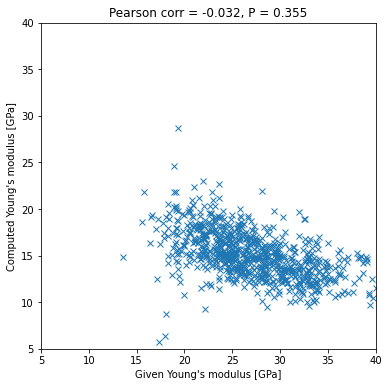

In [4]:
E = df_producer['Youngs modulus, GPa']    #given so-called "Young's modulus"

#Computing the actual Young's modulus 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

E_computed = rho*Vs**2*(3*Vp**2 - 4*Vs**2)/(Vp**2 - Vs**2)

#Dropping nan value
mask = np.logical_or(np.isnan(E), np.isnan(E_computed))
E = E[~mask]
E_computed = E_computed[~mask]

#compute corr coeff
corr = pearsonr(E, E_computed)


plt.figure(figsize = (6, 6))
plt.plot(E, E_computed/1e9, 'x')
plt.xlim([5, 40])
plt.ylim([5, 40])
plt.xlabel("Given Young's modulus [GPa]")
plt.ylabel("Computed Young's modulus [GPa]")
plt.title("Pearson corr = {:.3f}, P = {:.3f}".format(corr[0], corr[1]))

Text(0.5, 1.0, 'Pearson corr = 0.694, P = 0.000')

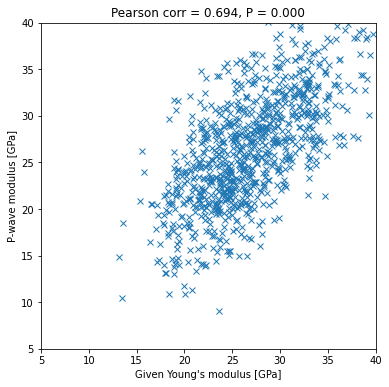

In [5]:
E = df_producer['Youngs modulus, GPa']    #given so-called "Young's modulus"

#Guessing that the "Young' modulus" is mistakenly labelled 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

M = Vp**2 * rho

#Dropping nan value
mask = np.logical_or(np.isnan(E), np.isnan(M))
E = E[~mask]
M = M[~mask]

#compute corr coeff
corr = pearsonr(E, M)


plt.figure(figsize = (6, 6))
plt.plot(E, M/1e9, 'x')
plt.xlim([5, 40])
plt.ylim([5, 40])
plt.xlabel("Given Young's modulus [GPa]")
plt.ylabel("P-wave modulus [GPa]")
plt.title("Pearson corr = {:.3f}, P = {:.3f}".format(corr[0], corr[1]))

## Checking acoustic impedance 

We check if the acoustic impedance is the P-acoustic impedance or S-acoustic impedance. Apparently, we do not know how the Hackathon organizer computes the acoustic impedance. Both computed P-acoustic impedance and S-acoustic impedance do not show a strong correlation with the given acoustic impedance.  

Text(0.5, 1.0, 'Pearson corr = 0.271, p = 0.0')

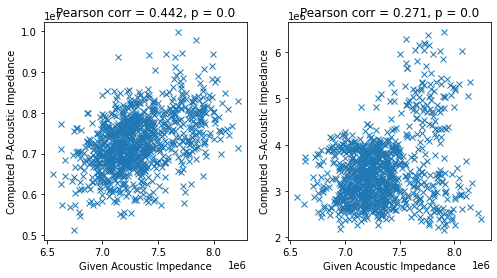

In [6]:
AI = df_producer['Acoustic Impedance, kg*s/m^2']    #given so-called "Young's modulus"

#Computing the actual Young's modulus 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

AI_P = rho * Vp
AI_S = rho * Vs

#Dropping nan value
AI0 = AI.copy()
mask = np.logical_or(np.isnan(AI0), np.isnan(AI_P))
AI0 = AI0[~mask]
AI_P = AI_P[~mask]

AI = AI.copy()
mask = np.logical_or(np.isnan(AI), np.isnan(AI_S))
AI = AI[~mask]
AI_S = AI_S[~mask]


#compute corr coeff
corr_P = pearsonr(AI0, AI_P)
corr_S = pearsonr(AI, AI_S)


fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(AI0, AI_P, 'x')
ax[0].set_xlabel("Given Acoustic Impedance")
ax[0].set_ylabel("Computed P-Acoustic Impedance")
ax[0].set_title("Pearson corr = {:.3f}, p = {:.1f}".format(corr_P[0], corr_P[1]))

ax[1].plot(AI, AI_S, 'x')
ax[1].set_xlabel("Given Acoustic Impedance")
ax[1].set_ylabel("Computed S-Acoustic Impedance")
ax[1].set_title("Pearson corr = {:.3f}, p = {:.1f}".format(corr_S[0], corr_S[1]))

## Imputation

### First step --> Equation imputation (Vp, Vs, density, and moduli)
The first step of the data imputation (filling missing value) is based on rock physics equations. Assuming that rock samples are isotropic, the relationship between P-wave velocity ($ V_p $), S-wave velocity ($ V_s $), Shear modulus ($ \mu $), P-wave modulus ($ M $), and density ($ \rho $) is:

$$
V_p = \sqrt{\frac{M} {\rho}} \\
V_s = \sqrt{\frac{\mu} {\rho}}
$$

Note that rocks have poisson's ratio greater than 0. Therefore, under the isotropic assumpion, the following inequality must hold:
$$
\frac{V_p}{V_s} \geq \sqrt{2}
$$

In [7]:
##Start imputation 
df_producer_imputed = df_producer.copy()

##Physics-controlled imputation --> using rock physics equations to impute data

##### Vs = sqrt(shearModulus / density)
#Impute shear modulus USING shear velocity and density 
mask = df_producer_imputed['Shear modulus, GPa'].isna()
df_producer_imputed.loc[mask, 'Shear modulus, GPa'] =  1000*df_producer_imputed[mask]['Density, g/cm3']*df_producer_imputed[mask]['Shear velocity, m/s']**2/1e9
#Impute shear velocity USING shear modulus and density 
mask = df_producer_imputed['Shear velocity, m/s'].isna()
df_producer_imputed.loc[mask, 'Shear velocity, m/s'] = np.sqrt(df_producer_imputed[mask]['Shear modulus, GPa']*1e9 / df_producer_imputed[mask]['Density, g/cm3']/1000)

##### NOTE THAT YOUNG's Modulus SHOULD BE P-WAVE modulus 

##### Vp = sqrt( (K + 4/3mu) / density) = sqrt(M/ density)
#Impute "Young's modulus" from P-velocity (Compressible velocity)  
mask = df_producer_imputed['Youngs modulus, GPa'].isna()
df_producer_imputed.loc[mask, 'Youngs modulus, GPa'] = 1000*df_producer_imputed[mask]['Density, g/cm3']*df_producer_imputed[mask]['Compressible velocity, m/s']**2/1e9
#Impute P-velocity (Compressible velocity) from "Young's modulus"
mask = df_producer_imputed['Compressible velocity, m/s'].isna()
df_producer_imputed.loc[mask, 'Compressible velocity, m/s'] = np.sqrt(df_producer_imputed[mask]['Youngs modulus, GPa']*1e9 / df_producer_imputed[mask]['Density, g/cm3']/1000)


##### Imputing density from Vp
mask = df_producer_imputed['Density, g/cm3'].isna()
df_producer_imputed.loc[mask, 'Density, g/cm3'] = df_producer_imputed[mask]['Youngs modulus, GPa']*1e9 / df_producer_imputed[mask]['Compressible velocity, m/s']**2 / 1000

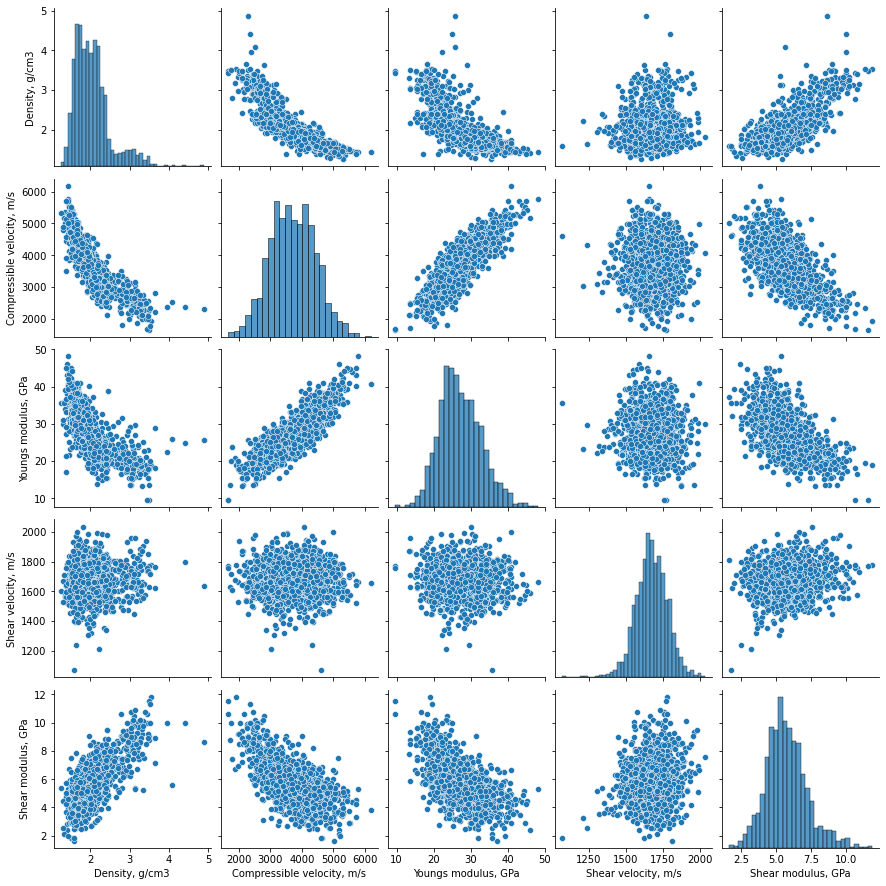

In [8]:
## Checking imputation data before moving forward
sns.pairplot(df_producer_imputed[['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']])

In [9]:
## Statistics checking 
df_producer_imputed.describe()

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1460.000000,1268.000000,284.000000,1.357000e+03,1417.000000,1415.000000,1407.000000,1410.000000,1421.000000
mean,4188.698630,5770.890411,3055.810959,0.127746,112.182739,7.325786e+06,2.051543,3701.209495,27.207492,1675.765333,5.758870
std,1771.495039,2389.773641,4.353335,0.036020,80.894436,3.101125e+05,0.449881,721.546485,5.633797,107.209256,1.501275
min,1175.000000,775.000000,3045.620000,0.040270,2.214604,6.559277e+06,1.255980,1661.828496,9.562034,1069.298522,1.650985
25%,2925.000000,3825.000000,3052.720000,0.113953,51.540980,7.111056e+06,1.723442,3194.503128,23.340885,1607.376885,4.762031
50%,3875.000000,6125.000000,3055.790000,0.137495,93.980722,7.274333e+06,1.978284,3674.753166,26.580455,1675.421416,5.615064
75%,5325.000000,7625.000000,3058.982500,0.152325,154.584890,7.503378e+06,2.233306,4219.335682,30.865723,1747.740881,6.600503
max,7975.000000,9775.000000,3066.300000,0.188910,489.219402,8.249272e+06,4.879421,6179.653016,48.123292,2035.772029,11.820038


In [10]:
df_producer_imputed.isna().sum()

Well_ID                            0
X, m                               0
Y, m                               0
Depth, m                           0
Porosity, fraction               192
Permeability, mD                1176
Acoustic Impedance, kg*s/m^2     103
Rock facies                      130
Density, g/cm3                    43
Compressible velocity, m/s        45
Youngs modulus, GPa               53
Shear velocity, m/s               50
Shear modulus, GPa                39
dtype: int64

### Second step --> Rock facies imputation (classify rock with Vp, Vs, density, and moduli)

The second step fills missing values using statistical approach. First, we fill the rock facies with the elastic attributes (i.e., Vp, Vs, moduli) and the density. To do so, we transform the rock facies log from vategorical value into a range from 0 to 1 where 1 represents shale and 0 represent sand. This is similar to the clay content log (Vclay). Then, imputing these values with other log. 

In [11]:
#Finding the missing  value in the Rock facies and use kNN to impute the data
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']

# 0 - 1 scaling 
df_scaled = df_producer_imputed[featureList].copy()
df_scaled_target = df_producer_imputed['Rock facies']

df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

##### Splitting known rows VS unknown rows
##training 
df_knownValue = df_scaled[~df_scaled_target.isna()]
df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
#drop nan
mask1 = df_knownValue.isna().any(axis = 1)
df_knownValue_1 = df_knownValue[~mask1]
df_knownValue_target_1 = df_knownValue_target[~mask1]

##testing 
df_unknownValue = df_scaled[df_scaled_target.isna()]
#drop nan
mask2 = df_unknownValue.isna().any(axis = 1)
df_unknownValue_2 = df_unknownValue[~mask2]

#kNN classification 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(df_knownValue_1, df_knownValue_target_1)

kNNprediction = neigh.predict(df_unknownValue_2)

##assemble everything back to the original dataframe 
mask = np.logical_and(df_producer_imputed['Rock facies'].isna(), ~df_producer_imputed[featureList].isna().any(axis = 1))
df_producer_imputed.loc[mask, 'Rock facies'] = kNNprediction

In [12]:
## Create a numerical 'Vclay' log
df_producer_imputed['Vclay'] = df_producer_imputed['Rock facies']
df_producer_imputed['Vclay'].replace({'Sandstone': 0, 'Shaly sandstone': 0.3333, 'Sandy shale': 0.6667, 'Shale': 1, np.nan: np.nan}, inplace = True)

In [13]:
df_producer_imputed.head()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa",Vclay
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717,0.0
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120,0.0
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,5.330842,0.0
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763,0.0
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,25.569990,1636.846284,5.277834,0.0


### Third step --> Filling acoustic impedance

In [14]:
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']

# 0 - 1 scaling 
df_scaled = df_producer_imputed[featureList].copy()
df_scaled_target = df_producer_imputed['Acoustic Impedance, kg*s/m^2']

df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

##### Splitting known rows VS unknown rows
##training 
df_knownValue = df_scaled[~df_scaled_target.isna()]
df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
#drop nan
mask1 = df_knownValue.isna().any(axis = 1)
df_knownValue_1 = df_knownValue[~mask1]
df_knownValue_target_1 = df_knownValue_target[~mask1]

##testing 
df_unknownValue = df_scaled[df_scaled_target.isna()]
#drop nan
mask2 = df_unknownValue.isna().any(axis = 1)
df_unknownValue_2 = df_unknownValue[~mask2]

#Random forest regressor 
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 100, max_depth = 4)
regr.fit(df_knownValue_1, df_knownValue_target_1)

randomForestprediction = regr.predict(df_unknownValue_2)

##assemble everything back to the original dataframe 
mask = np.logical_and(df_producer_imputed['Acoustic Impedance, kg*s/m^2'].isna(), ~df_producer_imputed[featureList].isna().any(axis = 1))
df_producer_imputed.loc[mask, 'Acoustic Impedance, kg*s/m^2'] = randomForestprediction

### Fourth step --> Filling porosity

<AxesSubplot:xlabel='Porosity, fraction', ylabel='Compressible velocity, m/s'>

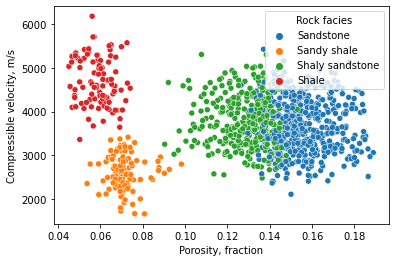

In [15]:
plt.figure()
sns.scatterplot(data = df_producer, x = 'Porosity, fraction', y = 'Compressible velocity, m/s', hue = 'Rock facies')

<AxesSubplot:xlabel='Porosity, fraction', ylabel='Acoustic Impedance, kg*s/m^2'>

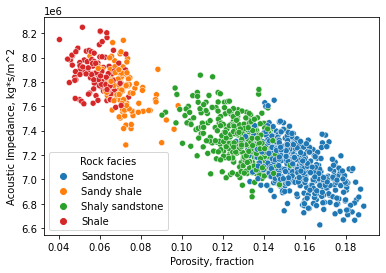

In [16]:
plt.figure()
sns.scatterplot(data = df_producer, x = 'Porosity, fraction', y = 'Acoustic Impedance, kg*s/m^2', hue = 'Rock facies')

<AxesSubplot:xlabel='Compressible velocity, m/s', ylabel='Shear velocity, m/s'>

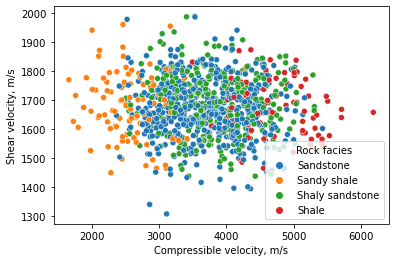

In [17]:
sns.scatterplot(data = df_producer, x = 'Compressible velocity, m/s', y = 'Shear velocity, m/s', hue = 'Rock facies')

In [18]:
df_producer_imputed.isna().sum()

Well_ID                            0
X, m                               0
Y, m                               0
Depth, m                           0
Porosity, fraction               192
Permeability, mD                1176
Acoustic Impedance, kg*s/m^2       6
Rock facies                       12
Density, g/cm3                    43
Compressible velocity, m/s        45
Youngs modulus, GPa               53
Shear velocity, m/s               50
Shear modulus, GPa                39
Vclay                             12
dtype: int64